# 1. Unconfined Aquifer Test - Vennebulten
**This example is taken from Kruseman et al. (1970).**

### Import packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import ttim as ttm

plt.rcParams["figure.figsize"] = [5, 3]

### Introduction and Conceptual Model

In aquifer tests in unconfined aquifers, there is also the vertical component to flow to the well. The drawdown data shows the delayed water table response, a distinguishable S-shape in the log-log plot. In the early times of the drawdown, the drawdown behaves as a confined aquifer: when the aquifer releases the elastic storage. However, as pumping continues, the water table storage begins to be released, generating further drawdown and the S-shape.

This test conducted in Vennebulten, the Netherlands, is reported in Kruseman et al. (1970). The cross-section consists of a first layer up to 6 m depth of very fine and loamy sands, followed by coarse sands until 21 m deep.

In this example, we will reproduce the work of Xinzhu (2020) that compared different conceptualizations in TTim to various solutions presented in the original report (Kruseman et al., 1970) and in other software, MLU (Carson & Randall, 2012) and AQTESOLV (Duffield, 2007).

The screen of the pumping well is placed between 10 and 21 meters depth, and pumping has taken place for 25 hours at a rate of 873 m3/d. The available drawdown data comes from two piezometers, a shallow one, screened at 3 m depth, and a deeper one, screened in the depths between 12 to 19 m. Both wells are located 90 m from the pumping well.

The conceptual model of the aquifer is displayed below:



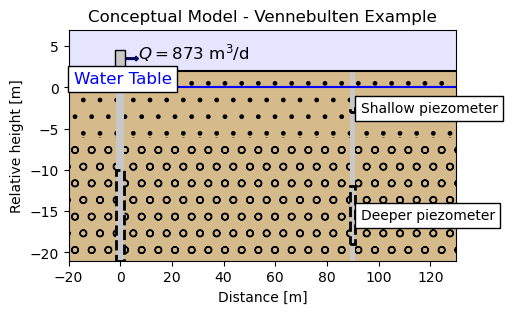

In [2]:
import matplotlib.pyplot as plt

##Now printing the conceptual model figure:

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
# sky
sky = plt.Rectangle((-20, 2), width=150, height=5, fc="b", zorder=0, alpha=0.1)
ax.add_patch(sky)

# Aquifer:
ground = plt.Rectangle(
    (-20, -6),
    width=150,
    height=8,
    fc=np.array([209, 179, 127]) / 255,
    zorder=0,
    alpha=0.9,
    hatch=".",
)
ax.add_patch(ground)

# Aquifer 2:
ground2 = plt.Rectangle(
    (-20, -21),
    width=150,
    height=15,
    fc=np.array([209, 179, 127]) / 255,
    zorder=0,
    alpha=0.9,
    hatch="o",
)
ax.add_patch(ground2)


well = plt.Rectangle(
    (-1.5, -21), width=3, height=23, fc=np.array([200, 200, 200]) / 255, zorder=1
)
ax.add_patch(well)

# Wellhead
wellhead = plt.Rectangle(
    (-2, 2), width=4, height=2.5, fc=np.array([200, 200, 200]) / 255, zorder=2, ec="k"
)
ax.add_patch(wellhead)

# Screen for the well:
screen = plt.Rectangle(
    (-1.5, -21),
    width=3,
    height=11,
    fc=np.array([200, 200, 200]) / 255,
    alpha=1,
    zorder=2,
    ec="k",
    ls="--",
)
screen.set_linewidth(2)
ax.add_patch(screen)
pumping_arrow = plt.Arrow(x=2, y=3.5, dx=5, dy=0, color="#00035b")
ax.add_patch(pumping_arrow)
ax.text(x=7, y=3.5, s=r"$ Q = 873$ m$^3$/d", fontsize="large")

# Piezometers
piez1 = plt.Rectangle(
    (89, -21), width=2, height=23, fc=np.array([200, 200, 200]) / 255, zorder=1
)
screen_piez_1 = plt.Rectangle(
    (89, -19),
    width=2,
    height=7,
    fc=np.array([200, 200, 200]) / 255,
    alpha=1,
    zorder=2,
    ec="k",
    ls="--",
)
screen_piez_1.set_linewidth(2)
screen_piez_2 = plt.Rectangle(
    (89, -3),
    width=2,
    height=0.5,
    fc=np.array([200, 200, 200]) / 255,
    alpha=1,
    zorder=2,
    ec="k",
    ls="--",
)
screen_piez_2.set_linewidth(2)

ax.add_patch(piez1)
ax.add_patch(screen_piez_1)
ax.add_patch(screen_piez_2)


# last line
line = plt.Line2D(xdata=[-200, 1200], ydata=[2, 2], color="k")
ax.add_line(line)

# Water table
line2 = plt.Line2D(xdata=[-200, 1200], ydata=[0, 0], color="b")
ax.add_line(line2)

ax.text(-18, 0.5, s="Water Table", fontsize="large", color="b", bbox={"fc": "w"})
ax.text(93, -3, s="Shallow piezometer", bbox={"fc": "w"})
ax.text(93, -16, s="Deeper piezometer", bbox={"fc": "w"})

ax.set_xlim([-20, 130])
ax.set_ylim([-21, 7])
ax.set_xlabel("Distance [m]")
ax.set_ylabel("Relative height [m]")
ax.set_title("Conceptual Model - Vennebulten Example");

### Set basic parameters

In [3]:
b = -21  # aquifer thickness, m
r = 90  # distance from observation wells to pumping well, m
Q = 873  # constant discharge, m^3/d

### Load data of the two piezometers

In [4]:
data1 = np.loadtxt("data/venne_shallow.txt", skiprows=1)
ts = data1[:, 0] / 60 / 24  # convert min to days
hs = data1[:, 1]

data2 = np.loadtxt("data/venne_deep.txt", skiprows=1)
td = data2[:, 0] / 60 / 24  # convert min to days
hd = data2[:, 1]

### Create a conceptual one-layer model

Both Kruseman et al. (1970) and AQTESOLV solutions that use the Neuman method (Neumann, 1969) assume a one layer unconfined model.
To compare TTim with both, we begin by modelling a one-layer aquifer.

For the unconfined test, the preferred method for modelling is to use the ```Model3D``` class. ```Model3D``` assumes the system is a vertical stacking of aquifer layers. Vertical flow is computed between layers by calculating the vertical resistance between layers. Vertical resistance between the aquifer layers is determined as the resistance from the middle of one layer to the middle of the next layer. The vertical anisotropy can be specified for each layer.

Model construction is similar to the ```ModelMaq``` class. We detail it below:

For our Model3D model, we have to set:

- The hydraulic conductivity: ```kaq```. It is a list/array with a float element for every aquifer, for example: ```[kaq0,kaq1]```. We can also set a float value. In this case, the same ```kaq``` is assumed for every layer.
- The top and bottom of each aquifer: ```z``` defined by a list/array ```[zt0,zb0,zt1,zb1,...]```, where the inputs are a sequence of top and bottoms of the aquifer layers.
- The specific storage: ```Saq```. It is a list/array with a float element for every aquifer, for example: ```[Saq0, Saq1]```. We can also set a float value. In this case, the same ```Saq``` is assumed for every layer.
- The minimum time for which TTim solve the groundwater flow: ```tmin```, a float.
- And the maximum time: ```tmax```, float.
- TTim automatically assumes the ```topboundary``` is confined. In this case, we also assume the ```topboundary``` is confined, so we do not need to set this parameter. In the code example, the parameter is set for clarity.
- The vertical anisotropy, defined by the parameter: ```kzoverkh```, which means the vertical hydraulic conductivity divided by the horizontal conductivity. This parameter is a list/array with a float element for every aquifer, for example: ```[kzoverkh0,kzoverkh1]```. We can also set a float value. In this case, the same ```kzoverkh``` is assumed for every layer. If one does not set this parameter, a isotropic model is considered: ```kzoverkh = 1```
- ```phreatictop```: Is a boolean (True/False). If ```True```, the first element in ```Saq``` is considered phreatic storage (Specific Yield) and is not multiplied by the layer thickness. The default value is ```True```. This parameter is relevant for the unconfined aquifer test, and we will show underneath how to set it.

To reproduce the one-layer aquifer model in Kruseman et al. (1970), we will build a two-layer Model3D model. The first layer is a very thin (0.1 m thick) layer with phreatic storage, followed by the 21 m thick aquifer layer. This thin layer is how TTim accounts for the water table storage in the unconfined situation. The first conceptual model is represented in the image below.


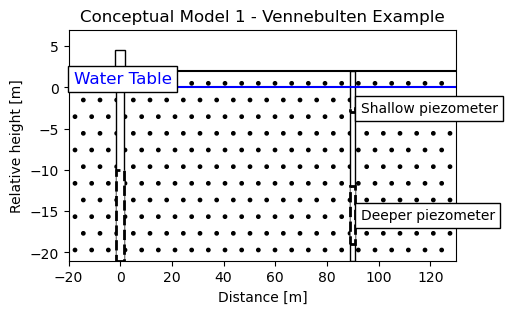

In [5]:
# Model Figure - One - layer model
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)


# Aquifer:
ground = plt.Rectangle(
    (-20, -21), width=150, height=23, fc="w", zorder=0, alpha=0.9, hatch="."
)
ax.add_patch(ground)

well = plt.Rectangle((-1.5, -21), width=3, height=23, fc="w", zorder=1, ec="k")
ax.add_patch(well)

# Wellhead
wellhead = plt.Rectangle((-2, 2), width=4, height=2.5, fc="w", zorder=2, ec="k")
ax.add_patch(wellhead)

# Screen for the well:
screen = plt.Rectangle(
    (-1.5, -21), width=3, height=11, fc="w", alpha=1, zorder=2, ec="k", ls="--"
)
screen.set_linewidth(2)
ax.add_patch(screen)

# Piezometers
piez1 = plt.Rectangle((89, -21), width=2, height=23, fc="w", zorder=1, ec="k")
screen_piez_1 = plt.Rectangle(
    (89, -19), width=2, height=7, fc="w", alpha=1, zorder=2, ec="k", ls="--"
)
screen_piez_1.set_linewidth(2)
screen_piez_2 = plt.Rectangle(
    (89, -3), width=2, height=0.5, fc="w", alpha=1, zorder=2, ec="k", ls="--"
)
screen_piez_2.set_linewidth(2)

ax.add_patch(piez1)
ax.add_patch(screen_piez_1)
ax.add_patch(screen_piez_2)


# last line
line = plt.Line2D(xdata=[-200, 1200], ydata=[2, 2], color="k")
ax.add_line(line)

# Water table
line2 = plt.Line2D(xdata=[-200, 1200], ydata=[0, 0], color="b")
ax.add_line(line2)

ax.text(-18, 0.5, s="Water Table", fontsize="large", color="b", bbox={"fc": "w"})
ax.text(93, -3, s="Shallow piezometer", bbox={"fc": "w"})
ax.text(93, -16, s="Deeper piezometer", bbox={"fc": "w"})

ax.set_xlim([-20, 130])
ax.set_ylim([-21, 7])
ax.set_xlabel("Distance [m]")
ax.set_ylabel("Relative height [m]")
ax.set_title("Conceptual Model 1 - Vennebulten Example");

In [6]:
ml_1 = ttm.Model3D(
    kaq=10,
    z=[0, -0.1, b],
    Saq=[0.1, 1e-4],
    tmin=1e-4,
    tmax=1.1,
    kzoverkh=1,
    phreatictop=True,
)
w_1 = ttm.Well(ml_1, xw=0, yw=0, rw=0.1, tsandQ=[(0, Q)])
ml_1.solve()

self.neq  1
solution complete


### Calibrate the one layer model with the shallow piezometer

We begin the initial model by adding the shallow observation well as the observation for the residuals calibration. And we calibrate hydraulic conductivity, specific yield and specific storage of our one layer unconfined aquifer:

In [7]:
# calibrate with data of shallow piezometer
# unknown parameters: kaq, Saq
ca_1 = ttm.Calibrate(ml_1)
ca_1.set_parameter(name="kaq0_1", initial=10)
ca_1.set_parameter(name="Saq0", initial=0.2)
ca_1.set_parameter(name="Saq1", initial=1e-4, pmin=0)
ca_1.set_parameter(name="kzoverkh0_1", initial=1, pmin=1e-5)
ca_1.series(name="obs", x=r, y=0, t=ts, h=hs, layer=0)  # shallow piezometer
ca_1.fit()

.....................................................................................................................................................
Fit succeeded.


In [8]:
display(ca_1.parameters)
print(f"RMSE: {ca_1.rmse():.4f} m")

,optimal,std,perc_std,pmin,pmax,initial,parray
kaq0_1,132.497947,5.850132,4.415262,-inf,inf,10.0000,"[132.49794744095647, 132.49794744095647]"
Saq0,-0.026176,0.046748,178.594011,-inf,inf,0.2000,[-0.026175550379415664]
Saq1,0.002108,0.002176,103.205788,0.00000,inf,0.0001,[0.002108316392783749]
kzoverkh0_1,3.345379,3.739321,111.775706,0.00001,inf,1.0000,"[3.3453791717676915, 3.3453791717676915]"


RMSE: 0.0030 m


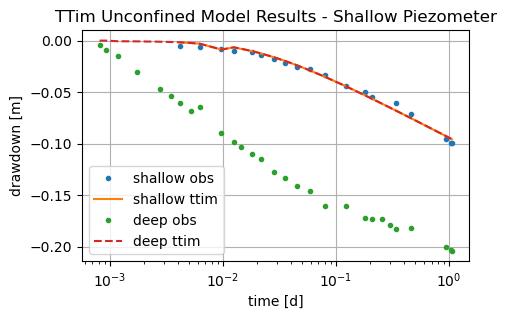

In [9]:
hs_1 = ml_1.head(r, 0, ts)
hd_1 = ml_1.head(r, 0, td)
plt.semilogx(ts, hs, ".", label="shallow obs")
plt.semilogx(ts, hs_1[0], label="shallow ttim")
plt.semilogx(td, hd, ".", label="deep obs")
plt.semilogx(td, hd_1[0], "--", label="deep ttim")
plt.xlabel("time [d]")
plt.ylabel("drawdown [m]")
plt.title("TTim Unconfined Model Results - Shallow Piezometer")
plt.legend()
plt.grid()

### Calibrate the one layer model with the deeper piezometer

In this second approach, we adjust the model to the deeper piezometer, as done by Kruseman and de Ridder (1970).

In [10]:
# calibrate with data of deeper piezometer
# unknown parameters: kaq, Saq, kzoverkh
ca_2 = ttm.Calibrate(ml_1)
ca_2.set_parameter(name="kaq0_1", initial=10, pmin=1e-8)
ca_2.set_parameter(name="Saq1", initial=1e-4, pmin=1e-5)
ca_2.set_parameter(name="Saq0", initial=0.2, pmin=1e-8)
ca_2.set_parameter(name="kzoverkh0_1", initial=1, pmin=1e-5)
ca_2.series(name="obs", x=r, y=0, t=td, h=hd, layer=0)  # deep piezometer
ca_2.fit()

..................................................................................................................................................................................................................
Fit succeeded.


In [11]:
display(ca_2.parameters)
print("RMSE:", ca_2.rmse())

,optimal,std,perc_std,pmin,pmax,initial,parray
kaq0_1,136.845159,5.769378e+00,4.215990,1.000000e-08,inf,10.0000,"[136.84515923564663, 136.84515923564663]"
Saq1,0.000010,9.560501e-08,0.956016,1.000000e-05,inf,0.0001,[1.0000356947981182e-05]
Saq0,0.000044,4.479922e-06,10.254135,1.000000e-08,inf,0.2000,[4.368892779782474e-05]
kzoverkh0_1,0.004536,5.683402e-04,12.529132,1.000000e-05,inf,1.0000,"[0.004536150130718286, 0.004536150130718286]"


RMSE: 0.0059183857395334405


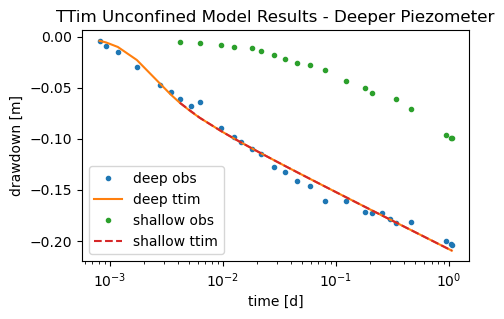

In [12]:
hd_2 = ml_1.head(r, 0, td)
hs_2 = ml_1.head(r, 0, ts)
plt.semilogx(td, hd, ".", label="deep obs")
plt.semilogx(td, hd_2[0], label="deep ttim")
plt.semilogx(ts, hs, ".", label="shallow obs")
plt.semilogx(ts, hs_2[0], "--", label="shallow ttim")
plt.xlabel("time [d]")
plt.ylabel("drawdown [m]")
plt.title("TTim Unconfined Model Results - Deeper Piezometer")
plt.legend();

### Create a conceptual model with n-layers

As we can see in the examples of step 5, the single-layer simplification does not represent the system well as we have a vertical component to flow, shown in the head difference between both piezometers.

We now explore the feature of TTim to create a multi-layer model to represent better the unconfined system and simulate the vertical flow component. We will discretize the aquifer in a 21 layer model, with 1 m thick each.

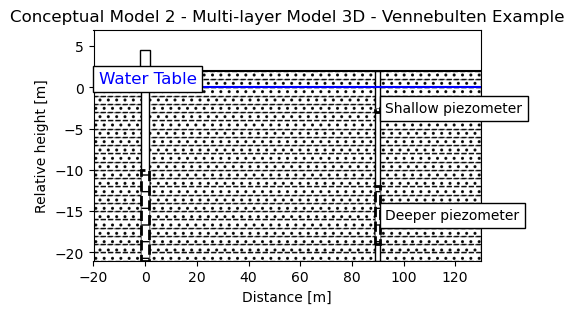

In [13]:
# Model Figure - One - layer model
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)


# Aquifer:
for i in range(21, -2, -1):
    ground = plt.Rectangle(
        (-20, -i),
        width=150,
        height=1,
        fc="w",
        zorder=0,
        alpha=0.9,
        hatch="..",
        ec="k",
        ls="--",
    )
    ax.add_patch(ground)


well = plt.Rectangle((-1.5, -21), width=3, height=23, fc="w", zorder=1, ec="k")
ax.add_patch(well)

# Wellhead
wellhead = plt.Rectangle((-2, 2), width=4, height=2.5, fc="w", zorder=2, ec="k")
ax.add_patch(wellhead)

# Screen for the well:
screen = plt.Rectangle(
    (-1.5, -21),
    width=3,
    height=11,
    fc="w",
    alpha=1,
    zorder=2,
    ec="k",
    ls="--",
    hatch="-",
)
screen.set_linewidth(2)
ax.add_patch(screen)

# Piezometers
piez1 = plt.Rectangle((89, -21), width=2, height=23, fc="w", zorder=1, ec="k")
screen_piez_1 = plt.Rectangle(
    (89, -19), width=2, height=7, fc="w", alpha=1, zorder=2, ec="k", ls="--", hatch="-"
)
screen_piez_1.set_linewidth(2)
screen_piez_2 = plt.Rectangle(
    (89, -3), width=2, height=0.5, fc="w", alpha=1, zorder=2, ec="k", ls="--", hatch="-"
)
screen_piez_2.set_linewidth(2)

ax.add_patch(piez1)
ax.add_patch(screen_piez_1)
ax.add_patch(screen_piez_2)


# last line
line = plt.Line2D(xdata=[-200, 1200], ydata=[2, 2], color="k")
ax.add_line(line)

# Water table
line2 = plt.Line2D(xdata=[-200, 1200], ydata=[0, 0], color="b")
ax.add_line(line2)

ax.text(-18, 0.5, s="Water Table", fontsize="large", color="b", bbox={"fc": "w"})
ax.text(93, -3, s="Shallow piezometer", bbox={"fc": "w"})
ax.text(93, -16, s="Deeper piezometer", bbox={"fc": "w"})

ax.set_xlim([-20, 130])
ax.set_ylim([-21, 7])
ax.set_xlabel("Distance [m]")
ax.set_ylabel("Relative height [m]")
ax.set_title("Conceptual Model 2 - Multi-layer Model 3D - Vennebulten Example");

In [14]:
nlay = 21  # number of layers
zlayers = np.linspace(0, b, nlay + 1)  # elevation of each layer
Saq = 1e-4 * np.ones(nlay)
Saq[0] = 0.1  # Setting the first storage as specific yield

The model is created just as in the previous step, however with the new parameters defined above:

In [15]:
ml_2 = ttm.Model3D(
    kaq=10, z=zlayers, Saq=Saq, kzoverkh=0.1, phreatictop=True, tmin=1e-4, tmax=1.1
)
w_2 = ttm.Well(ml_2, xw=0, yw=0, rw=0.1, tsandQ=[(0, Q)], layers=range(nlay))
ml_2.solve()

self.neq  21
solution complete


### Calibrate multi-layer model with the two piezometers simultaneously

In the TTim multi-layer model, we can fit the parameters using data from both piezometers simultaneously.
For this initial assumption, we assume the aquifer has one hydraulic conductivity and storage parameter.

The unknown parameters are kaq, Saq, kzoverkh.

Now, on the ```series``` method, we have to remember to set a different layer for each piezometer, corresponding to the depth of the screen.

In [16]:
ca_3 = ttm.Calibrate(ml_2)
ca_3.set_parameter(name="kaq0_20", initial=10)
ca_3.set_parameter(name="Saq0", initial=0.2)
ca_3.set_parameter(name="Saq1_20", initial=1e-4)
ca_3.set_parameter(name="kzoverkh0_20", initial=0.1, pmin=1e-5, pmax=0.5)
ca_3.series(name="obs1", x=r, y=0, layer=1, t=ts, h=hs)
ca_3.series(name="obs2", x=r, y=0, layer=15, t=td, h=hd)
ca_3.fit(report=True)

.............................................................
Fit succeeded.
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 58
    # data points      = 48
    # variables        = 4
    chi-square         = 0.00243050
    reduced chi-square = 5.5239e-05
    Akaike info crit   = -466.761301
    Bayesian info crit = -459.276496
[[Variables]]
    kaq0_20:       59.3574445 +/- 2.85482618 (4.81%) (init = 10)
    Saq0:          0.03005722 +/- 0.00252459 (8.40%) (init = 0.2)
    Saq1_20:       3.3850e-05 +/- 2.1163e-06 (6.25%) (init = 0.0001)
    kzoverkh0_20:  0.00152234 +/- 2.5876e-04 (17.00%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(kaq0_20, kzoverkh0_20) = -0.9548
    C(kaq0_20, Saq0)         = -0.5934
    C(kaq0_20, Saq1_20)      = -0.5598
    C(Saq0, kzoverkh0_20)    = +0.5134
    C(Saq1_20, kzoverkh0_20) = +0.4769
    C(Saq0, Saq1_20)         = +0.3186


In [17]:
display(ca_3.parameters)
print("RMSE:", ca_3.rmse())

,optimal,std,perc_std,pmin,pmax,initial,parray
kaq0_20,59.357445,2.854826,4.809550,-inf,inf,10.0000,"[59.357444540804096, 59.357444540804096, 59.35..."
Saq0,0.030057,0.002525,8.399289,-inf,inf,0.2000,[0.030057222790710464]
Saq1_20,0.000034,0.000002,6.252124,-inf,inf,0.0001,"[3.384998672499465e-05, 3.384998672499465e-05,..."
kzoverkh0_20,0.001522,0.000259,16.997596,0.00001,0.5,0.1000,"[0.001522344436417982, 0.001522344436417982, 0..."


RMSE: 0.007115852666850155


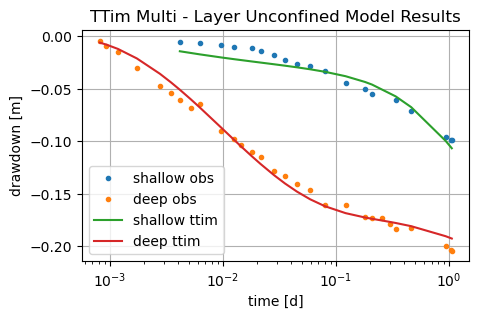

In [18]:
hs_3 = ml_2.head(x=r, y=0, t=ts, layers=1)
hd_3 = ml_2.head(x=r, y=0, t=td, layers=15)
plt.semilogx(ts, hs, ".", label="shallow obs")
plt.semilogx(td, hd, ".", label="deep obs")
plt.semilogx(ts, hs_3[0], label="shallow ttim")
plt.semilogx(td, hd_3[0], label="deep ttim")
plt.xlabel("time [d]")
plt.ylabel("drawdown [m]")
plt.title("TTim Multi - Layer Unconfined Model Results")
plt.legend()
plt.grid()

We already see significant improvement from the previous single-layer model. The fit is better and the AIC and BIC indicators have also significantly improved.

What if we take into account the described stratification of the aquifer? In that case, we could try to stratify our model into two: The first 6 m and the deeper layers.

### Calibration of the Stratified Model

In this final example, we will assume the storage is distributed according to the sediment stratification in the aquifer. We will adjust two different ```Saq```values, one for the first 6 m of the aquifer and another for the deeper layers. We assume the hydraulic conductivity and the anisotropy is constant.

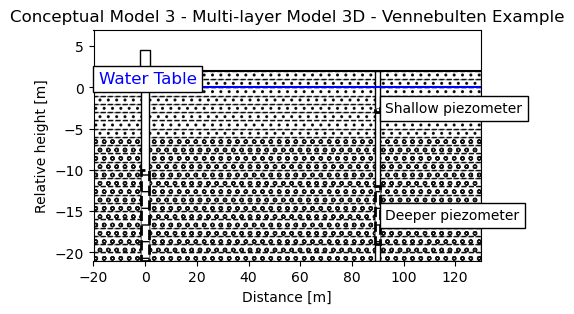

In [19]:
# Model Figure - One - layer model
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)


# Aquifer 1:
for i in range(21, 6, -1):
    ground = plt.Rectangle(
        (-20, -i),
        width=150,
        height=1,
        fc="w",
        zorder=0,
        alpha=0.9,
        hatch="oo",
        ec="k",
        ls="--",
    )
    ax.add_patch(ground)
# Aquifer 2:
for i in range(6, -2, -1):
    ground = plt.Rectangle(
        (-20, -i),
        width=150,
        height=1,
        fc="w",
        zorder=0,
        alpha=0.9,
        hatch="..",
        ec="k",
        ls="--",
    )
    ax.add_patch(ground)


well = plt.Rectangle((-1.5, -21), width=3, height=23, fc="w", zorder=1, ec="k")
ax.add_patch(well)

# Wellhead
wellhead = plt.Rectangle((-2, 2), width=4, height=2.5, fc="w", zorder=2, ec="k")
ax.add_patch(wellhead)

# Screen for the well:
screen = plt.Rectangle(
    (-1.5, -21),
    width=3,
    height=11,
    fc="w",
    alpha=1,
    zorder=2,
    ec="k",
    ls="--",
    hatch="-",
)
screen.set_linewidth(2)
ax.add_patch(screen)

# Piezometers
piez1 = plt.Rectangle((89, -21), width=2, height=23, fc="w", zorder=1, ec="k")
screen_piez_1 = plt.Rectangle(
    (89, -19), width=2, height=7, fc="w", alpha=1, zorder=2, ec="k", ls="--", hatch="-"
)
screen_piez_1.set_linewidth(2)
screen_piez_2 = plt.Rectangle(
    (89, -3), width=2, height=0.5, fc="w", alpha=1, zorder=2, ec="k", ls="--", hatch="-"
)
screen_piez_2.set_linewidth(2)

ax.add_patch(piez1)
ax.add_patch(screen_piez_1)
ax.add_patch(screen_piez_2)


# last line
line = plt.Line2D(xdata=[-200, 1200], ydata=[2, 2], color="k")
ax.add_line(line)

# Water table
line2 = plt.Line2D(xdata=[-200, 1200], ydata=[0, 0], color="b")
ax.add_line(line2)

ax.text(-18, 0.5, s="Water Table", fontsize="large", color="b", bbox={"fc": "w"})
ax.text(93, -3, s="Shallow piezometer", bbox={"fc": "w"})
ax.text(93, -16, s="Deeper piezometer", bbox={"fc": "w"})

ax.set_xlim([-20, 130])
ax.set_ylim([-21, 7])
ax.set_xlabel("Distance [m]")
ax.set_ylabel("Relative height [m]")
ax.set_title("Conceptual Model 3 - Multi-layer Model 3D - Vennebulten Example");

In [20]:
ml_3 = ttm.Model3D(
    kaq=10, z=zlayers, Saq=Saq, kzoverkh=0.1, phreatictop=True, tmin=1e-4, tmax=1.1
)
w_3 = ttm.Well(ml_3, xw=0, yw=0, rw=0.1, tsandQ=[(0, Q)], layers=range(nlay))
ml_3.solve()

self.neq  21
solution complete


In [21]:
ca_4 = ttm.Calibrate(ml_3)
ca_4.set_parameter(name="kaq0_20", initial=50)
ca_4.set_parameter(name="Saq0", initial=0.1)
ca_4.set_parameter(name="Saq1_7", initial=1e-4, pmin=0)
ca_4.set_parameter(name="Saq7_20", initial=1e-4, pmin=0)
ca_4.set_parameter(name="kzoverkh0_20", initial=0.1, pmin=1e-5, pmax=0.5)
ca_4.series(name="obs1", x=r, y=0, layer=1, t=ts, h=hs)
ca_4.series(name="obs2", x=r, y=0, layer=15, t=td, h=hd)
ca_4.fit()

.................................................................................................................
Fit succeeded.


In [22]:
display(ca_4.parameters)
print("RMSE:", ca_4.rmse())

,optimal,std,perc_std,pmin,pmax,initial,parray
kaq0_20,73.371456,2.931042,3.994798,-inf,inf,50.0000,"[73.37145562442105, 73.37145562442105, 73.3714..."
Saq0,0.021280,0.002079,9.772022,-inf,inf,0.1000,[0.02128009026680317]
Saq1_7,0.000421,0.000061,14.400714,0.00000,inf,0.0001,"[0.0004206754841473703, 0.0004206754841473703,..."
Saq7_20,0.000024,0.000001,4.945612,0.00000,inf,0.0001,"[2.3670441879897197e-05, 2.3670441879897197e-0..."
kzoverkh0_20,0.000435,0.000123,28.191660,0.00001,0.5,0.1000,"[0.0004347006679574145, 0.0004347006679574145,..."


RMSE: 0.0034378856797220685


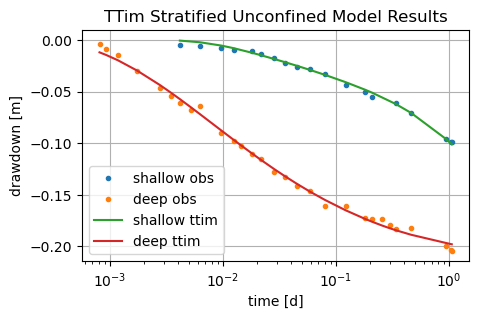

In [23]:
hs_4 = ml_3.head(x=r, y=0, t=ts, layers=1)
hd_4 = ml_3.head(x=r, y=0, t=td, layers=15)
plt.semilogx(ts, hs, ".", label="shallow obs")
plt.semilogx(td, hd, ".", label="deep obs")
plt.semilogx(ts, hs_4[0], label="shallow ttim")
plt.semilogx(td, hd_4[0], label="deep ttim")
plt.xlabel("time [d]")
plt.ylabel("drawdown [m]")
plt.title("TTim Stratified Unconfined Model Results")
plt.legend()
plt.grid()

Here we see that the model fit has significantly improved. AIC and BIC indicators are lower than the previous multi-layer model.

### Comparison of results

In [24]:
t2 = pd.DataFrame(
    columns=["k [m/d]", "Sy [-]", "Ss [1/m]", "kzoverkh"],
    index=["MLU", "ttim-multilayer", "ttim-stratified Ss"],
)
t2.loc["MLU"] = [62.657, 0.0012, 2.790e-05, 0.002595]
t2.loc["ttim-multilayer"] = ca_3.parameters["optimal"].values
t2.iloc[2, 0:2] = ca_4.parameters["optimal"].values[0:2]
t2.iloc[2, 2:4] = ca_4.parameters["optimal"].values[3:5]
t2.loc[:, "RMSE"] = pd.Series([0.013540, ca_3.rmse(), ca_4.rmse()], index=t2.index)
t2

,k [m/d],Sy [-],Ss [1/m],kzoverkh,RMSE
MLU,62.657,0.0012,0.000028,0.002595,0.013540
ttim-multilayer,59.357445,0.030057,0.000034,0.001522,0.007116
ttim-stratified Ss,73.371456,0.02128,0.000024,0.000435,0.003438


The multi-layer approach allowed us to fit both piezometers and better represent the vertical component of flow. However, the parameters were sensitive to the conceptualization applied. The stratified model had much larger hydraulic conductivity in comparison to the multi-layer model. In the stratified approach, the fit has significantly improved.

## References

* Carlson F, Randall J (2012) MLU: a Windows application for the analysis of aquifer tests and the design of well fields in layered systems. Ground Water 50(4):504–510
* Duffield, G.M., 2007. AQTESOLV for Windows Version 4.5 User's Guide, HydroSOLVE, Inc., Reston, VA.
* Kruseman, G.P., De Ridder, N.A., Verweij, J.M., 1970. Analysis and evaluationof pumping test data. volume 11. International institute for land reclamation and improvement The Netherlands.
* Neuman, S.P., Witherspoon, P.A., 1969. Applicability of current theories of flow in leaky aquifers. Water Resources Research 5, 817–829.
* Yang, Xinzhu (2020) Application and comparison of different methodsfor aquifer test analysis using TTim. Master Thesis, Delft University of Technology (TUDelft), Delft, The Netherlands.